In [1]:
import tensorflow as tf, os, pandas as pd, numpy as np, pickle, glob
from sklearn.model_selection import KFold
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

2023-04-04 08:36:50.812334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 08:36:50.916838: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 08:36:51.478519: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-04 08:36:51.478575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
USD_data_train_pkl = glob.glob("../process_csv/PeriHD_pickle_save/BERT_sample2693_fulltext/train/*.pkl")
USD_data_test_pkl = glob.glob("../process_csv/PeriHD_pickle_save/BERT_sample2693_fulltext/test/*.pkl")

In [3]:
def pk2pf(pkl_list):
    data_train = []
    for pk in pkl_list:
        with open(pk, 'rb') as f:
            pk_dict = pickle.load(f)
        data_train.append(pk_dict)
    data_train = pd.DataFrame(data_train)
    
    return data_train
BERT_data_train = pk2pf(BERT_data_train_pkl)
BERT_data_test = pk2pf(BERT_data_test_pkl)

In [4]:
BERT_data_train_embedding = np.array(BERT_data_train['full_embed'].tolist())
BERT_data_test_embedding = np.array(BERT_data_test['full_embed'].tolist())

/tmp/ipykernel_53772/3113612830.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  BERT_data_train_embedding = np.array(BERT_data_train['full_embed'].tolist())
/tmp/ipykernel_53772/3113612830.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  BERT_data_test_embedding = np.array(BERT_data_test['full_embed'].tolist())


In [5]:
print(len(BERT_data_train.label.values)-sum(BERT_data_train.label.values), sum(BERT_data_train.label.values))
print(len(BERT_data_test.label.values)-sum(BERT_data_test.label.values), sum(BERT_data_test.label.values))

2288 405
74 26


In [6]:
# BERT_internal_embeddings = np.load("./feature_vector/BERT_internal_embeddings.npy", allow_pickle=True)
# BERT_external_validation_embeddings = np.load("./feature_vector/BERT_external_validation_embeddings.npy", allow_pickle=True)
# print("BERT External test", BERT_external_validation_embeddings.shape)
# print("BERT Internal test", BERT_internal_embeddings.shape)

# USD_internal_embeddings = np.load("./feature_vector/USD_internal_embeddings.npy", allow_pickle=True)
# USD_external_validation_embeddings = np.load("./feature_vector/USD_external_validation_embeddings.npy", allow_pickle=True)
# print("USD External test", USD_external_validation_embeddings.shape)
# print("USD Internal test", USD_internal_embeddings.shape)
# Fusion_intranal_embeddings = []
# for usb, bert in zip(USD_internal_embeddings, BERT_internal_embeddings):
#     fu_usb_bert_single = np.concatenate((usb, bert), axis=1)
#     Fusion_intranal_embeddings.append(fu_usb_bert_single)

# Fusion_external_validation_embeddings = []
# for usb, bert in zip(USD_external_validation_embeddings, BERT_external_validation_embeddings):
#     fu_usb_bert_single = np.concatenate((usb, bert), axis=1)
#     Fusion_external_validation_embeddings.append(fu_usb_bert_single)

In [7]:
import keras
def create_model(input_shape = (1024,)):
  model = tf.keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
  return model

2023-03-10 23:24:45.531958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 23:24:46.506744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
0it [00:00, ?it/s]2023-03-10 23:24:48.893757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2693it [04:12, 10.65it/s]
100it [00:08, 11.86it/s]
2693it [03:45, 11.96it/s]
100it [00:17,  5.57it/s]
2693it [03:31, 12.71it/s]
100it [00:07, 12.57it/s]
2693it [03:17, 13.65i

Text(0.5, 1.0, '[External][BERT]PeriHD full-sentence ROC-Curve')

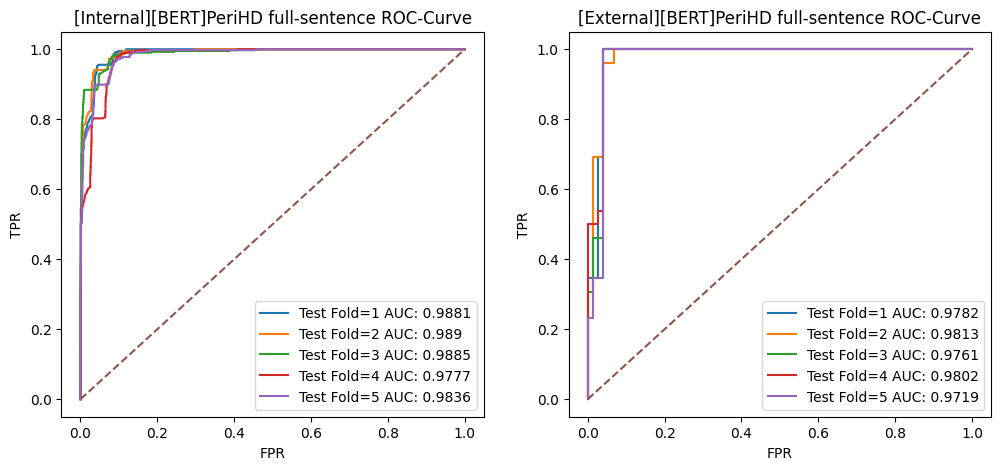

In [8]:
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from tqdm import tqdm
def get_weight_path(fold, train_type):
    # return './model_weight/weights_periHD_KFold={}[Fusion].h5'.format(fold)
    return './model_weight/weights_periHD_KFold={}[{}].h5'.format(fold,train_type)
kfold = KFold(n_splits=5, shuffle=True)
gt_in = BERT_data_train.label.values
gt_ex = BERT_data_test.label.values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
CM_internal = []
CM_external = []
train_type = 'BERT'
input_shape  = (512,)
Fusion_intranal_embeddings = BERT_data_train_embedding
Fusion_external_validation_embeddings = BERT_data_test_embedding
for fold in ['1','2','3','4','5']:
# for fold in ['1']:
    weight_name = get_weight_path(fold, train_type)
    model_cls = create_model(input_shape=input_shape)
    model_cls.load_weights(weight_name)
    # Internal metric
    split_data_internal = {"pred":[], "truth": []}
    train_pred_seq_stack =[]
    for (seq_stack, ans) in tqdm(zip(Fusion_intranal_embeddings, gt_in)):
        test_pred = model_cls.predict(seq_stack,verbose=0)
        train_pred_seq_stack.append(test_pred)
        split_data_internal['pred'].append(np.max(test_pred))
        split_data_internal['truth'].append(ans)
    test_binary_pred1 = (np.array(split_data_internal['pred'])>0.5).astype(np.int8)
    tn, fp, fn, tp = confusion_matrix(split_data_internal['truth'], test_binary_pred1).ravel()
    CM_internal.append([tn, fp, fn, tp])
    fpr, tpr, thresholds = roc_curve(split_data_internal['truth'], split_data_internal['pred'], pos_label=1)
    auc = roc_auc_score(split_data_internal['truth'], split_data_internal['pred'])
    axs[0].plot(fpr, tpr, label = "Test Fold={} AUC: {}".format(fold, round(auc, 4)))
    # External metric
    split_data_external = {"pred":[], "truth": []}
    test_pred_seq_stack =[]
    for (seq_stack, ans) in tqdm(zip(Fusion_external_validation_embeddings, gt_ex)):
        test_pred = model_cls.predict(seq_stack, verbose=0)
        test_pred_seq_stack.append(test_pred)
        split_data_external['pred'].append(np.max(test_pred))
        split_data_external['truth'].append(ans)
    test_binary_pred2 = (np.array(split_data_external['pred'])>0.3).astype(np.int8)
    tn, fp, fn, tp = confusion_matrix(split_data_external['truth'], test_binary_pred2).ravel()
    CM_external.append([tn, fp, fn, tp])
    fpr, tpr, thresholds = roc_curve(split_data_external['truth'], split_data_external['pred'], pos_label=1)
    auc = roc_auc_score(split_data_external['truth'], split_data_external['pred'])
    axs[1].plot(fpr, tpr, label = "Test Fold={} AUC: {}".format(fold, round(auc, 4)))

axs[0].plot([0,1],[0,1], linestyle='--')
axs[1].plot([0,1],[0,1], linestyle='--')
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")
axs[0].set_title(f"[Internal][{train_type}]PeriHD full-sentence ROC-Curve")
axs[1].set_title(f"[External][{train_type}]PeriHD full-sentence ROC-Curve")


In [9]:
# USD_external_validation_embeddings = []
# # for idx, (text, ans) in enumerate(zip(external_data_test['處置其他結束（描述）'], external_data_test['Truth'])):
# for idx, (text, ans) in enumerate(zip(internal_data['處置其他結束（描述）'], internal_data['Truth'])):
#     text = text.replace('\t','').replace('\n','').replace('。','，').replace(',','，')
#     text_sp = np.array([i for i in text.split('，') if len(i)>0])
#     USD_external_validation_embeddings.append(text_sp)
# USD_external_validation_embeddings = np.array(USD_external_validation_embeddings)
# false_pred = pd.DataFrame([], columns=['index', 'Pred score', 'Sentence', 'Answer', 'Predict'])
# # for idx, (ex_ans, ex_pre) in enumerate(zip(gt_ex, test_binary_pred)):
# for idx, (ex_ans, ex_pre) in enumerate(zip(gt_in, test_binary_pred1)):
#     print(ex_ans)
#     break
# #         if (ex_ans!=ex_pre) and ex_ans==1:
# #             temp = pd.DataFrame([], columns=['index', 'Pred score','Sentence', ])
# #             temp['index'] = [idx] * len(test_pred_seq_stack[idx])
# #             temp['Sentence'] = USD_external_validation_embeddings[idx]
# #             temp['Pred score'] = np.round(test_pred_seq_stack[idx],3)
# #             temp['Answer'] = ["透析中低血壓"if ex_ans==1 else "非透析中低血壓"]+['-']*(len(test_pred_seq_stack[idx])-1)
# #             temp['Predict'] = ["透析中低血壓"if ex_pre==1 else "非透析中低血壓"]+['-']*(len(test_pred_seq_stack[idx])-1)
# #             false_pred = pd.concat([false_pred, temp])
# # false_pred['index'] = false_pred['index'].astype(int)

In [10]:
# false_pred.to_csv('./False_predict_sentence_data.csv', encoding='utf-8-sig', index=False)

In [11]:
# 已標記資料效能評估
def metric_calc(array_):
    tn, fp, fn, tp = array_
    acc = (tp+tn)/(tp+tn+fn+fp)
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    prec = tp/(tp+fp)
    f1 = (2*prec*sens)/(prec+sens)
    return acc, prec, sens, spec, f1

def get_metric(arr):
    mean_arr = np.mean(np.array(arr), axis=0)
    std_arr = np.std(np.array(arr), axis=0)
    return mean_arr, std_arr

In [12]:

CM_train = np.array(CM_internal)
CM_test = np.array(CM_external)
T_stack, t_stack = [],[]
for T_ in CM_train:
    T_stack.append(metric_calc(T_))
    
for t_ in CM_test:
    t_stack.append(metric_calc(t_))
#內部資料 - Train & Test
mark_train_mean, mark_train_std = get_metric(T_stack)
mark_test_mean, mark_test_std = get_metric(t_stack)
mark_train = pd.DataFrame(['Accuracy','Precision', 'Sensitivity', 'Specificity', 'F1-score'], columns=[f'{train_type} Metric Train'])
for T_, f in zip(T_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_train[f] = np.round(T_,4)
mark_train['Mean'] = np.round(mark_train_mean,4)
mark_train['Std'] = np.round(mark_train_std,4)

mark_test = pd.DataFrame(['Accuracy','Precision', 'Sensitivity', 'Specificity', 'F1-score'], columns=[f'{train_type} Metric Test'])
for t_, f in zip(t_stack,['fold-1','fold-2','fold-3','fold-4','fold-5']):mark_test[f] = np.round(t_,4)
mark_test['Mean'] = np.round(mark_test_mean,4)
mark_test['Std'] = np.round(mark_test_std,4)

In [13]:
mark_train

,BERT Metric Train,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9265,0.9313,0.9283,0.9228,0.9239,0.9266,0.0031
1,Precision,0.6825,0.6971,0.6834,0.6743,0.6792,0.6833,0.0076
2,Sensitivity,0.9556,0.9605,0.9753,0.9407,0.9358,0.9536,0.0142
3,Specificity,0.9213,0.9261,0.9200,0.9196,0.9218,0.9218,0.0023
4,F1-score,0.7963,0.8079,0.8037,0.7856,0.7871,0.7961,0.0088


In [14]:
mark_test

,BERT Metric Test,fold-1,fold-2,fold-3,fold-4,fold-5,Mean,Std
0,Accuracy,0.9400,0.9300,0.9100,0.9500,0.9600,0.9380,0.0172
1,Precision,0.8125,0.7879,0.7429,0.8387,0.8667,0.8097,0.0425
2,Sensitivity,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
3,Specificity,0.9189,0.9054,0.8784,0.9324,0.9459,0.9162,0.0232
4,F1-score,0.8966,0.8814,0.8525,0.9123,0.9286,0.8942,0.0262
